# Austrian energy dependence on Russian gas imports

This model was developed from the tutorial model of the Austrian energy system by adding scenarios to simulate the Russian gas import constraint.

### Time and Spatial Detail
The model includes the time periods from 2010 to 2041 with 2-years intervals for more precise outcome.
This condition requires more calculations, therefore the GAMPs free licence should be upgraded.

###  Scenarios
To the baseline scenario were added the most benevolent scenarios in terms of renewables energy production and the negative scenario of total constraint of Russian gas import without replacement the imports from other countries. All scenarios are listed below:
- Wind power plants subsidies;
- Hydro power plants subsidies;
- Biofuel subsidies;
- Solar photovoltaics power plants subsidies;-Compact fluorescent lamp subsidies;
- Natural gas import constraints.

### Outcomes
An execution error emerges, when the model cannot find an optimal decision. In our case, the model had not found an optimal decision for any year of full stop of gas importation till the year 2034. This year was selected as a year of gas import constraints. Otherwise, according to the model, the constraints lead to the model collapse.

### Plots
Postprocessing and reporting of the model made by __message_ix.reporting__ and __message_ix.util.tutorial__ libraries built in the framework.

## Setup

In [49]:
# load required packages 
import pandas as pd
import numpy as np

from matplotlib.pyplot import style
from IPython.display import set_matplotlib_formats

import ixmp as ix
import message_ix
from message_ix.reporting import Reporter
from message_ix.util.tutorial import prepare_plots, solve_modified
from message_ix.testing import make_austria

%matplotlib inline
set_matplotlib_formats("svg")
style.use("ggplot")

C:\Users\kir_g\AppData\Local\Temp\ipykernel_16516\1638300151.py:15: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats("svg")


In [50]:
# launch the IX modeling platform using the local default databases
mp = ix.Platform()

In [51]:
# from multipolicies
country = "Austria"
horizon = range(2010, 2041, 2)

plants = [
    "bio_ppl", 
    "coal_ppl", 
    "gas_ppl", 
    "oil_ppl", 
    "hydro_ppl",
    "solar_pv_ppl",
    "wind_ppl", 
]

lights = ["bulb", "cfl"]

In [52]:
# Scenaio without share constraint
model = "Austrian energy model"
base = message_ix.Scenario(mp, model=model, scenario='baseline')
base_rep = Reporter.from_scenario(base)
prepare_plots(base_rep)

In [53]:
country = "Austria"
horizon = range(2010, 2041, 2)

plants = [
    "bio_ppl", 
    "coal_ppl", 
    "gas_ppl", 
    "oil_ppl", 
    "hydro_ppl",
    "solar_pv_ppl",
    "wind_ppl", 
]

lights = ["bulb", "cfl"]

# Wind Subsidies + Demand-Side Learning


In [54]:
# Percent subsidy by year
subsidies_wind = np.array([0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.25,0.25,0.25,0.25,0.25,0])
subsidies_hydro = np.array([0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.25,0.25,0.25,0.25,0.25,0])
subsidies_bio = np.array([0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.25,0.25,0.25,0.25,0.25,0])
subsidies_solar_pv = np.array([0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.25,0.25,0.25,0.25,0.25,0])
learning = np.array([1,1,1,1,1,0.6,0.6,0.6,0.6,0.6,0.3,0.3,0.3,0.3,0.3,0.1])

with solve_modified(base, new_name="wind+cfl_subsidies") as wind_scen:
    # Load the investment cost data (cloned from `base_scen`) for wind_ppl
    data = wind_scen.par("inv_cost", filters=dict(technology="wind_ppl"))
    
    # Reduce the values according to the subsidy
    data["value"] = data["value"] * (1 - subsidies_wind)
    
    # Overwrite the values in `wind_scen` at the same indices
    wind_scen.add_par("inv_cost", data)
    
    ########################
    
    # Load the investment cost data (cloned from `base_scen`) for wind_ppl
    data = wind_scen.par("inv_cost", filters=dict(technology="hydro_ppl"))
    
    # Reduce the values according to the subsidy
    data["value"] = data["value"] * (1 - subsidies_hydro)
    
    # Overwrite the values in `wind_scen` at the same indices
    wind_scen.add_par("inv_cost", data)
    
    ########################
    
    # Load the investment cost data (cloned from `base_scen`) for wind_ppl
    data = wind_scen.par("inv_cost", filters=dict(technology="bio_ppl"))
    
    # Reduce the values according to the subsidy
    data["value"] = data["value"] * (1 - subsidies_bio)
    
    # Overwrite the values in `wind_scen` at the same indices
    wind_scen.add_par("inv_cost", data)
    
    ########################
    
    # Load the investment cost data (cloned from `base_scen`) for wind_ppl
    data = wind_scen.par("inv_cost", filters=dict(technology="solar_pv_ppl"))
    
    # Reduce the values according to the subsidy
    data["value"] = data["value"] * (1 - subsidies_solar_pv)
    
    # Overwrite the values in `wind_scen` at the same indices
    wind_scen.add_par("inv_cost", data)
    
    ########################
    
    # Load the investment cost data (cloned from `base`) for cfl
    data = wind_scen.par("inv_cost", filters=dict(technology="cfl"))
    
    # Reduce the values according to the learning curve
    data["value"] = data["value"] * learning
    
    # Overwrite the values in `cfl_scen` at the same indices
    wind_scen.add_par("inv_cost", data)

## Steps required to add share constraints
The following steps are required in order to introduce a share constraint:
1. Define a new 'share' and add this to the *set* `shares`
2. Define which technologies contribute towards the total
3. Define which technologies contribute towards fullfilling the share
4. Define the share for relevant periods

The implementation of shares in MESSAGEix is generic and flexible, so that any combination of commodities, levels, technologies and nodes can be put in relation to any other combination.

Loading the scenario with existing policies '*base_ex_pol*' and cloning to a new scenario '*gas_constraint*' to add share constraints:

In [55]:
model = "Austrian energy model"
base_ex_pol = message_ix.Scenario(mp, model=model, scenario='wind+cfl_subsidies')
# Cloning with a new scenario name 'fossil_resources'
scen = base_ex_pol.clone(model, 'gas_constraint', 'illustration of gas-constraint formulation', keep_solution=False)
scen.check_out()

Retrieving required information for constructing input data of share parameters:

In [56]:
year_df = scen.vintage_and_active_years()
vintage_years, act_years = year_df['year_vtg'], year_df['year_act']
model_horizon = scen.set('year')
country = 'Austria'

### Step 1: Defining a new 'share' 
We define a new share called `share_renewable_electricity`, and add this to the *set* `shares`:

In [57]:
shares = 'share_with_gas_constraints'
scen.add_set('shares', shares)

### Step 2: Defining technologies that make up the total
We need to define which resource make up the group accounting for the total, to which the share applies. To do this, we need to map the share to relevant *commodity* and *level*.

The aim is to increase the share of electricity generated from all technology but `gas_ppl` to 100% in 2040. Therefore, we need to define, which technologies contribute to total electricity generation at the secondary energy level. In our example, these are `coal_ppl`, `gas_ppl`, `oil_ppl`, `bio_ppl`, `hydro_ppl`, `wind_ppl` and `solar_pv_ppl` technologies, which will be grouped as a new `type_tec`, called `electricity_total` in the scenario. For this `type_tec`, we need to define the relevant node, mode, level and commodity through the *set* `map_shares_commodity_total`.

In [58]:
type_tec = 'electricity_total'
scen.add_cat('technology', type_tec, 'coal_ppl')
scen.add_cat('technology', type_tec, 'gas_ppl')
scen.add_cat('technology', type_tec, 'oil_ppl')
scen.add_cat('technology', type_tec, 'bio_ppl')
scen.add_cat('technology', type_tec, 'hydro_ppl')
scen.add_cat('technology', type_tec, 'wind_ppl')
scen.add_cat('technology', type_tec, 'solar_pv_ppl')

For adding data to a MESSAGEix set or parameter, the index names must be correctly specified. To see the index names of a set or parameter, we can use the method: `scenario.idx_names()`.

In [59]:
# Example of index names of a set
scen.idx_names('map_shares_commodity_total')

['shares', 'node_share', 'node', 'type_tec', 'mode', 'commodity', 'level']

In [60]:
# Adding data to a set using index names
df = pd.DataFrame({'shares': [shares],
                   'node_share': country,
                   'node': country,
                   'type_tec': type_tec,
                   'mode': 'standard',
                   'commodity': 'electricity',
                   'level': 'secondary',
})
scen.add_set('map_shares_commodity_total', df)

In [61]:
alternatives = ['coal_ppl', 'oil_ppl', 'bio_ppl', 'hydro_ppl', 'wind_ppl', 'solar_pv_ppl']
all_technology = ['coal_ppl', 'gas_ppl', 'oil_ppl', 'bio_ppl', 'hydro_ppl', 'wind_ppl', 'solar_pv_ppl']

### Step 3: Defining technologies of share
Next, we define technologies that contribute towards fullfilling the share. We also need to set corresponding commodity and level for which the share constraint applies. In our example, the technology that provides 100% electricity from all sorts of technology but `gas_ppl` are `coal_ppl`, `oil_ppl`, `bio_ppl`, `hydro_ppl`, `wind_ppl` and `solar_pv_ppl`.

In [62]:
type_tec = 'share_with_gas_constraints'
# (!!!) I introduced the list "alternatives". In the tutorial it was only wind_ppl
scen.add_cat('technology', type_tec, alternatives)

# Reminder: use <scen.idx_names('map_shares_commodity_share')> to see the index names
df = pd.DataFrame({'shares': [shares],
                   'node_share': country,
                   'node': country,
                   'type_tec': type_tec,
                   'mode': 'standard',
                   'commodity': 'electricity',
                   'level': 'secondary',
})
scen.add_set('map_shares_commodity_share', df)

### Step 4: Defining the share
Lastly, the actual share value needs to be added to the model. To represent a minimum share of 93.3% of total electricity generation from alternatives (because the rest 6.7% are generated by `gas_ppl` which use available naturalgas), we use parameter `share_commodity_lo`. If this constraint should act as an upper bound, then parameter `share_commodity_up` can be used.

In [63]:
# Fetching the index names of a parameter
scen.idx_names('share_commodity_lo')

['shares', 'node_share', 'year_act', 'time']

In [64]:
# Adding data to the parameter
df = pd.DataFrame({'shares': shares,
                   'node_share': country,
                   'year_act': [2034],
                   'time': 'year',
                   'value': [0.933],
                   'unit': '-'})
scen.add_par('share_commodity_lo', df)

### Commit and solve

In [65]:
scen.commit(comment='define parameters for minimum alternative technologies share constraint')
scen.set_as_default()

In [66]:
scen.solve()

In [19]:
scen.var('OBJ')['lvl']

117271.4296875

# Plotting Results

In [20]:
from message_ix.reporting import Reporter
from message_ix.util.tutorial import prepare_plots

# Scenaio without share constraint
base_rep = Reporter.from_scenario(base)
prepare_plots(base_rep)

# Scenario with share constraint
rep = Reporter.from_scenario(scen)
prepare_plots(rep)

## Activity
***
In the new scenario ('*share_constraint*'), the activity of alternative technologies accounts for 93.3% of total electricity generation in 2040. This was the share constraint, we added to the scenario.

### Question:
The results show that the activity of alternative technologies in 2040 is slightly higher than the '*baseline*' too. Do you know why this happens? (see the response below)

<AxesSubplot:title={'center':'Austria Energy System New Capacity'}, xlabel='Year', ylabel='GWa'>

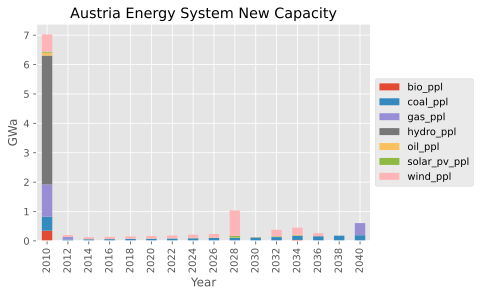

In [21]:
rep.set_filters(t=plants)
rep.get("plot new capacity")

<AxesSubplot:title={'center':'Austria Energy System New Capacity'}, xlabel='Year', ylabel='GWa'>

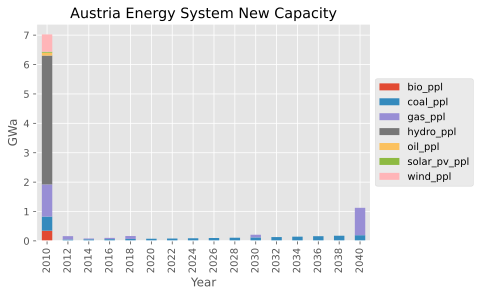

In [22]:
plants = all_technology
base_rep.set_filters(t=plants)
base_rep.get("plot new capacity")

### Scenario: '*base_ex_pol*'

<AxesSubplot:title={'center':'Austria Energy System Activity'}, xlabel='Year', ylabel='GWa'>

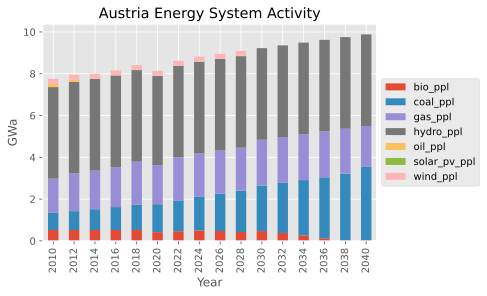

In [23]:
plants = all_technology
base_rep.set_filters(t=plants)
base_rep.get("plot activity")

### Scenario: '*gas_constraint*'

<AxesSubplot:title={'center':'Austria Energy System Activity'}, xlabel='Year', ylabel='GWa'>

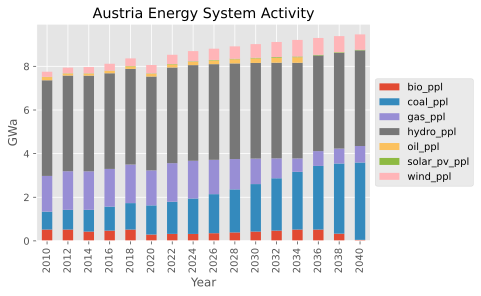

In [24]:
plants = all_technology
rep.set_filters(t=plants)
rep.get("plot activity")

### Scenario: '*baseline*'

<AxesSubplot:title={'center':'Austria Energy System Capacity'}, xlabel='Year', ylabel='GW'>

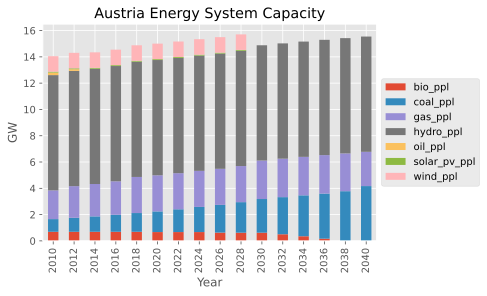

In [25]:
base_rep.get("plot capacity")

### Scenario: '*gas_constraint*'

<AxesSubplot:title={'center':'Austria Energy System Capacity'}, xlabel='Year', ylabel='GW'>

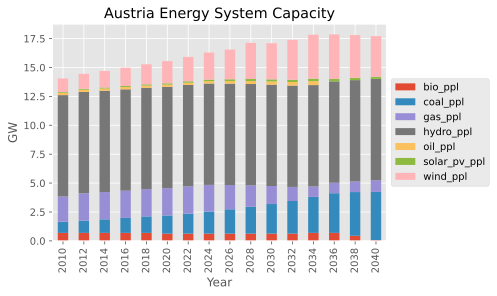

In [26]:
rep.get("plot capacity")

## Prices
***
As expected, electricity prices in 720 have also increased vis-a-vis the '*baseline*'

### Scenario: '*baseline*'

<AxesSubplot:title={'center':'Austria Energy System Prices'}, xlabel='Year', ylabel='¢/kW·h'>

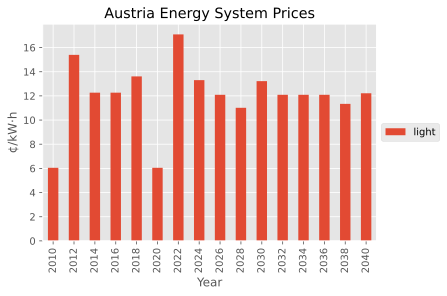

In [27]:
filters = dict(t=None, c=["light"])
base_rep.set_filters(**filters)
base_rep.get("plot prices")

### Scenario: '*gas_constraint*'

<AxesSubplot:title={'center':'Austria Energy System Prices'}, xlabel='Year', ylabel='¢/kW·h'>

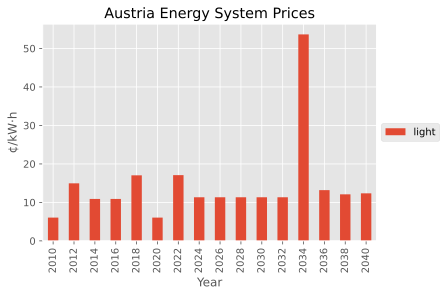

In [28]:
rep.set_filters(**filters)
rep.get("plot prices")

In [67]:
mp.close_db()